# Spanish Translation A/B Test

In this challenge, we analyze results from an A/B test. Background: Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking
countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local. That is,
Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!

You are asked to:
1. Confirm that the test is actually negative. That is, it appears that the old version of the
site with just one translation across Spain and LatAm performs better
2. Explain why that might be happening. Are the localized translations really worse?

In [1]:
# Import necessary libraries

import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats


## 1. Data overview and wrangling

In [2]:
# Import test table

df_test = pd.read_csv('test_table.csv')
df_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


Here we noticed that there are some missing values for the ads_channel.

In [4]:
# Import user table

df_user = pd.read_csv('user_table.csv')
df_user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [5]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


We noticed that the user table is busted and we have some users ids missing. 

In [6]:
# Now let's check if there are dupes

print(len(df_test) == len(df_test['user_id'].unique()))
print(len(df_user) == len(df_user['user_id'].unique()))

True
True


Now we need to join the two tables and while doing this, we have to be careful to not lose the user ids in the test table but not in the user table

In [7]:
df = pd.merge(left=df_test, right=df_user, how='left', on='user_id')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


## 2. A/B test

Now we first make sure it is true that Spain converts much better than the rest of LatAm countries.

In [12]:
grouped_country = df[df['test'] == 0][['country', 'conversion']].groupby('country').mean().reset_index().sort_values('conversion', ascending=False)
grouped_country

,country,conversion
14,Spain,0.079719
6,El Salvador,0.053554
10,Nicaragua,0.052647
4,Costa Rica,0.052256
3,Colombia,0.052089
8,Honduras,0.050906
7,Guatemala,0.050643
16,Venezuela,0.050344
13,Peru,0.049914
9,Mexico,0.049495


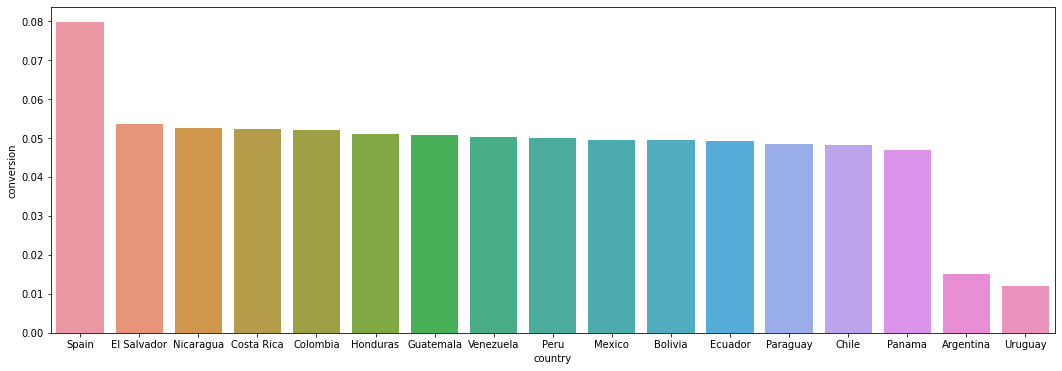

In [13]:
# Visualization

fig, ax = plt.subplots(figsize = (18, 6))
sns.barplot(x='country', y='conversion', data=grouped_country, ax=ax)
plt.show()

Indeed, it is true. Now let's run a simple A/B test:

In [14]:
# No need to keep Spain as it's irrelavant. 

test_df = df[df['country']!='Spain']

In [15]:
# Test and control group values.

test = test_df[test_df['test'] == 1]['conversion'].values
ctrl = test_df[test_df['test'] == 0]['conversion'].values

In [46]:
print('mean conversion rate for the test group: ', np.round(test.mean(), 3))
print('mean conversion rate for the control group: ', np.round(ctrl.mean(), 3))

mean conversion rate for the test group:  0.043
mean conversion rate for the control group:  0.048


In [18]:
print(stats.ttest_ind(test, ctrl, equal_var=False)) # unequal sample size

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


According to this p-value, the result is definitely worse. But in the test are converting at 4.8% while users in the test just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are:
1. We didn’t collect enough data.
2. Some bias has been introduced in the experiment so that test/control people are not really
random.

## 3. Analysis

Now let's find the bias that caused this unreasonable result.

In [19]:
# Remove the users in Spain as no test here

df = df[df['country']!='Spain']

In [26]:
# Dataframe obtained by sorting date values

df_temp = df.sort_values('date')

In [36]:
test_mean = df_temp[df_temp['test']==1].groupby('date')['conversion'].mean().values
ctrl_mean = df_temp[df_temp['test']==0].groupby('date')['conversion'].mean().values
test_vs_ctrl = test_mean/ctrl_mean

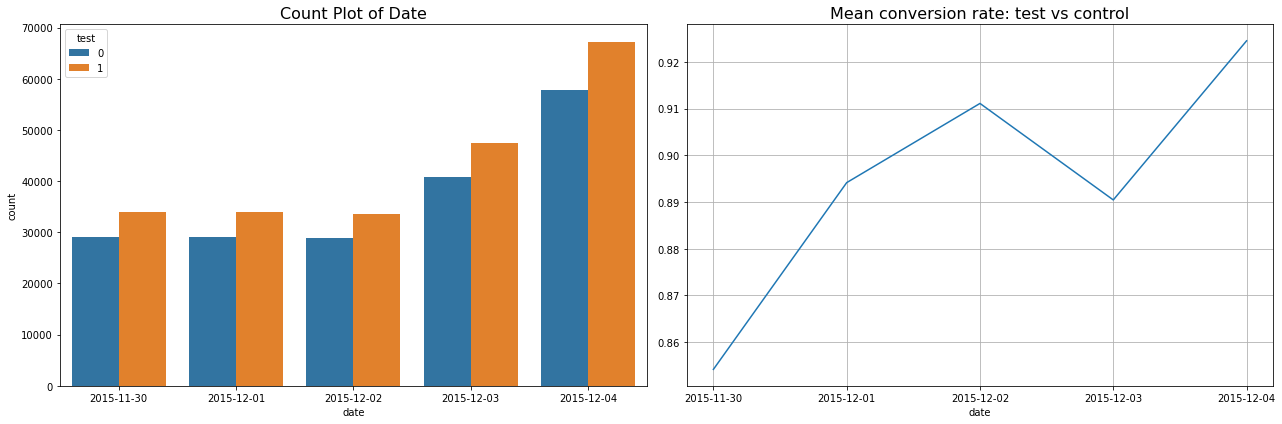

In [40]:
# Visualization of the data day by day.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='date', hue='test', data=df_temp, ax=ax[0])
ax[0].set_title('Count Plot of Date', fontsize=16)

# sns.barplot(x='date', y='conversion', hue='test', data=df_temp, ax=ax[1])
plt.plot(df_temp['date'].unique(), test_vs_ctrl)
ax[1].set_title('Mean conversion rate: test vs control', fontsize=16)
ax[1].set_xlabel('date')
ax[1].grid(True)
plt.tight_layout()
plt.show()

From the plot, we notice a couple of things:
1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.

### Bias

Time to find out the bias. Likely, there is for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/below conversion rate and this affected the overall results.

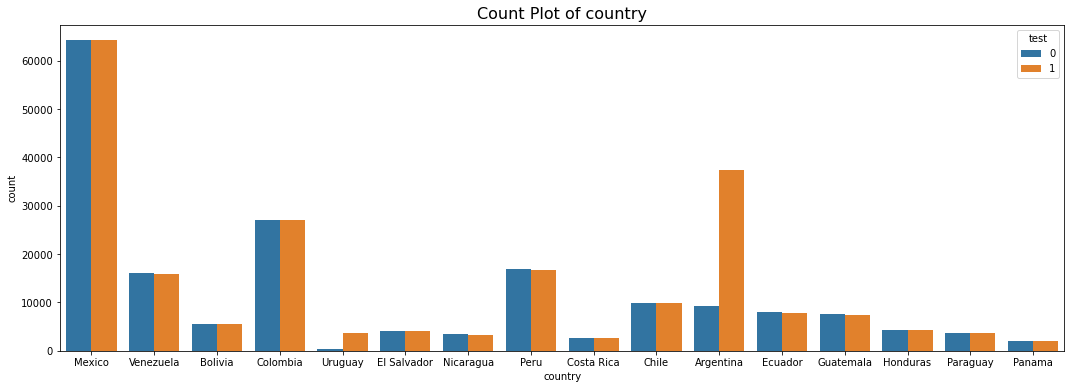

In [42]:
# Visualize by country

fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(x='country', hue='test', data=df, ax=ax)
ax.set_title('Count Plot of country', fontsize=16)
plt.show()

Looks very interesting. The randomization is perfect for the countries: Bolivia, Chile, Colombia, Costa Rica, Ecuador, EL Salvador, Guatemala, Honduras, Mexico,
Nicaragua, Panama, Paraguay, Peru, Venezuela, However, the test/control ratio is much higher for Argentina and Uruguay.

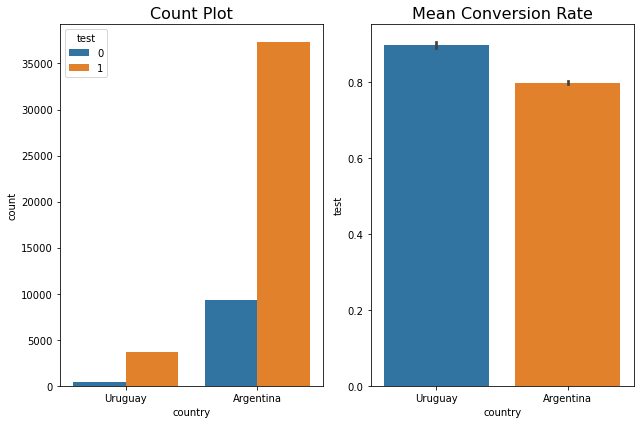

In [43]:
# Visualize conversion rate for Argentina and Uruguay

df_outlier = df[df['country'].isin(['Argentina', 'Uruguay'])][['test', 'country']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))
sns.countplot(x='country', hue='test', data=df_outlier, ax=ax[0])
ax[0].set_title('Count Plot', fontsize=16)

sns.barplot(x='country', y='test', data=df_outlier, ax=ax[1])
ax[1].set_title('Mean Conversion Rate', fontsize=16)
plt.tight_layout()
plt.show()

In [45]:
print('overall test/control rate for these two countries are: ', np.round(df_outlier['test'].mean(), 3))

overall test/control rate for these two countries are:  0.808


We have found the bias. Now let’s check the test results
after controlling for country. That is, we check for each country how the test is doing:

In [49]:
countries = df['country'].dropna().unique()

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('*' * 58)

for country in countries:
    test_val = df[(df['country'] == country) & (df['test'] == 1)]['conversion'].values
    cont_val = df[(df['country'] == country) & (df['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = stats.ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
**********************************************************
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849   0.8836

The test clearly appears non significant. Not a great success given that the
goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse.